# Meta-analysis of COVID-19 papers

### Project for Management and Analysis of Physics Datasets
***

By: LamBHrusco gang



The COVID-19 pandemic has seen an unprecedented increase in the number of papers published on a single topic.The mass of information that's now readily accessible has been giving a hard time to the scientist,doctors and researchers trying to navigate  this and finding what is useful.

That is why many Natural Language Processing (NPL) scientist have been tryng to sintesize the mass of papers and distill the useful information from them. This project uses ditributed processing frameworks to analyze the massive dataset of papers regarding the COVID-19 pandemic found at https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge . This dataset contains about ~200 000 thousands papers, we will work on just around 1000 due to our hardware limitation, but this code can be expanded to any cluster dimension.




## Cluster setup

emmò la situa si complica

In [1]:
import pandas as pd
import numpy  as np 
import time
import matplotlib.pyplot as plt
from dask.distributed import Client, LocalCluster

import dask.bag as db
import json
from urllib.request import urlopen

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator



In [2]:
cluster = LocalCluster(n_workers=4,threads_per_worker=2) 
client  = Client(cluster)
#client = Client('localhost:8786')
client

Client Scheduler: tcp://127.0.0.1:56072 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 8.43 GB


## Read of papers from JSON files

We will import JSON files and tranform them into Dask Bags

In [3]:
def opener_func(filename):
    f = open(filename,'r')
    dictio = json.load(f)
    f.close()
    return dictio

In [4]:

! rm dummy.mapd
! ls COVID_papers >> dummy.mapd 

with open('dummy.mapd') as file:
    flist = ['json1line_COVID_papers/'+i.strip() for i in file]
with open('dummy.mapd') as file:
    flistgit = ['https://raw.githubusercontent.com/Luca-Negri/Meta_Analysis_of_COVID_papers/main/json1line_COVID_papers/'+i.strip() for i in file]



b = db.read_text(flist).map(json.loads).repartition(8) 
b

"rm" non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
"ls" non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


dask.bag<reparti..., npartitions=8>

In [5]:
def concatenate_text(paper_dict):
    
    """Function to tranform the body text field of the json files into a clean and usable 
        format, by concatenating the sections and removing unwanted characters
        
        
        Arguments:
        paper_dict ::: python dictionary containing the paper read from the JSON files
        
        
        Returns:
        paper_dict ::: now the "body_text" contains all the text sections concatenated
        
        
        """
    print('Concatenate!' + paper_dict['paper_id'])
    
    body_text_list  = paper_dict['body_text'] #read of the text
    
    #concatenation of every section into one text file
    total_text = ''
    for text_section in body_text_list:
        total_text += text_section['text']
        
    total_text = total_text.lower()#lowercase everything
        
    # deteleting all unwanted characters
    
    
    forbidden_chars = ".,()[]:*><;°%/+'"
    for forbidden_ch in forbidden_chars:
        
        total_text = total_text.replace(forbidden_ch,"")
        
    #paper_dict['body_text'] = total_text
    
    return total_text
    
    
def word_count(body_text):
     
    """Function to count the occurencies of each word in the document using numpy functions
    
        Arguments:
        
        paper_dict ::: python dictionary containing the paper read from the JSON files
    
        
        Retrurns
        
        word_counts ::: python dictionary containing each word as key and the number of occurencies as value
    
    """
    
    #import numpy as np # define right namespace
    print('io conto!')
    #body_text = paper_dict['body_text']# get the text
    text_list = body_text.split() # transform into a list
    
    words, counts = np.unique(text_list, return_counts  = True) # count the words
    
    word_counts = {key : count for key,count in zip(words, counts)} # transform into a dictionary
    #paper_dict['word_count'] = word_counts # add dictionary  to json
    
    return word_counts


def word_dellamadonna(paper_dict):
    
    print('Concatenate!' + paper_dict['paper_id'])
    
    body_text_list  = paper_dict['body_text'] #read of the text
    
    #concatenation of every section into one text file
    total_text = ''
    for text_section in body_text_list:
        total_text += text_section['text']
        
    total_text = total_text.lower()#lowercase everything
        
    # deteleting all unwanted characters
    
    
    forbidden_chars = ".,()[]:*><;°%/+"
    
    for forbidden_ch in forbidden_chars:
        
        total_text = total_text.replace(forbidden_ch,"")
    
    total_text = total_text.replace('"','')
        
        
    #nofwords_counter
        
    text_list = total_text.split() # transform into a list
    
    words, counts = np.unique(text_list, return_counts  = True) # count the words
    
    word_counts = [(key , count) for key,count in zip(words, counts)]# transform into a dictionary
    #word_counts = [{key : count} for key,count in zip(words, counts)]# transform into a dictionary
    
    #paper_dict['word_count'] = word_counts # add dictionary  to json
    
    
    
    return word_counts

def word_dellamadonna2(body_text_list):
    
    #print('Concatenate!' + paper_dict['paper_id'])
    
    #body_text_list  = paper_dict['body_text'] #read of the text
    
    #concatenation of every section into one text file
    total_text = ''
    for text_section in body_text_list:
        total_text += text_section['text']
        
    total_text = total_text.lower()#lowercase everything
        
    # deteleting all unwanted characters
    
    
    forbidden_chars = ".,()[]:*><;°%/+-=1234567890"
    
    for forbidden_ch in forbidden_chars:
        
        total_text = total_text.replace(forbidden_ch,"")
    
    total_text = total_text.replace('"','')
        
        
    #nofwords_counter
        
    text_list = total_text.split() # transform into a list
    
    
    words, counts = np.unique(text_list, return_counts  = True) # count the words
    
    word_counts = [(key , count) for key,count in zip(words, counts)]

    
    
    
    return word_counts

    
    
    

In [6]:
def reduce_counts(word_list1,word_list2):
    
    """Combines the results od two dictionaries"""
    
    #obtaining the keys
    word_list_out = word_list1

    try:
        keys1 = list(word_list1.keys())
        keys2 = list(word_list2.keys())


        #add one value to the other
        for key2 in keys2:
                #check if already present
                if key2 not in keys1:
                    word_list_out[key2] = word_list2[key2]
                else:
                    word_list_out[key2] += word_list2[key2]
    except:
        pass
        
    return word_list_out
        
    
    

In [7]:
def add(x1,x2):
    return list(x1.items())[0][1] + list(x2.items())[0][1]

def add2(x1,x2):
    return x1 + x2[1]

def add3(a,b):
    return a+b

def binop(t, x):

    return max((t, x), key=lambda x: x[1])

In [8]:
#b_conc  = b.map(word_dellamadonna).flatten().foldby(lambda x:x[0],binop=add2)
b_conc = b.pluck('body_text').map(word_dellamadonna2).flatten().foldby(lambda x:x[0],binop=add2,initial=0,combine=add3,combine_initial=(0,0))
word_count = b_conc.compute()


In [9]:
word_count = {key[0]:key[1][0] for key in word_count}

In [10]:
oh_sort = dict(sorted(word_count.items(), key=lambda item: item[1])[::-1])

words_related_to_research = ['et','al','fig','data','study','number','model','results'
                             ,'figure','p','t','reported','public','table','studies','higher'
                            ,'different','population','shown','period','analysis','information']

words_related_to_COVID    = ['mers-cov','covid-19','patients','infection',
                             'rate','health','cases','virus','disease','human','pandemic',
                            'viral','autophagy','growth','response','nodules','lockdown',
                            'contact','cells','care','case','positive','protein','stem','epidemic'
                            ,'transimission','dna']

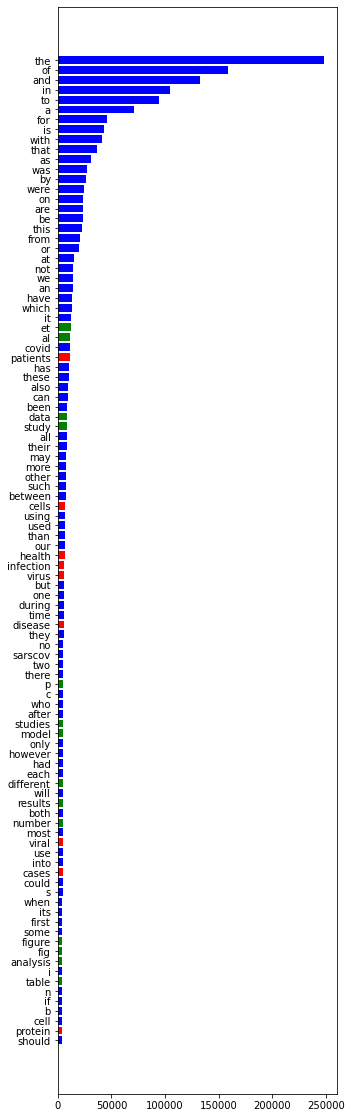

In [11]:
n_to_plot = 100
n_low = 0

list_of_vals = list(oh_sort.values())[n_low:n_to_plot]
list_of_keys = list(oh_sort.keys())[n_low:n_to_plot]

clist = []

for key in list_of_keys:
    
    if key in words_related_to_COVID:
        clist.append('red')
    elif key in words_related_to_research:
        clist.append('green')
    else:
        clist.append('blue')
    

plt.figure(figsize=[5,20])

plt.barh(list_of_keys[::-1],list_of_vals[::-1],color=clist[::-1])

#plt.xticks(rotation=60)

plt.show()

In [ ]:


w_cloud = WordCloud(width=1000,height=2000,background_color='black',colormap='cool',max_words=1000,prefer_horizontal=0.7).generate_from_frequencies(word_count)

plt.figure(figsize=[15,30])
plt.imshow(w_cloud, interpolation= 'bilinear')
plt.axis('off')
plt.savefig('Word_Cloud.png',dpi=100)
plt.show()

## Fastenss of the code
We will now try to chamnge the number of worker and partitions to see how the code could be made faster. 


In [12]:
client.close()
cluster.close()

In [13]:
partitions = [1,4,8,32,64,128]
workers = [1,2,4]
times_array=np.zeros([len(workers),len(partitions)])

for i in range(len(workers)):
    for j in range(len(partitions)):
        
        cluster = LocalCluster(n_workers= workers[i],threads_per_worker=2)
        client = Client(cluster)
        
        b = db.read_text(flist).map(json.loads).repartition(partitions[j])
        time1 = time.time()
        
        word_count = b.pluck('body_text').map(word_dellamadonna2).flatten().foldby(lambda x:x[0],binop=add2,initial=0,combine=add3,combine_initial=(0,0)).compute()
        
        times_array[i,j] = time.time() - time1
        
        client.close()
        cluster.close()
        
        
     


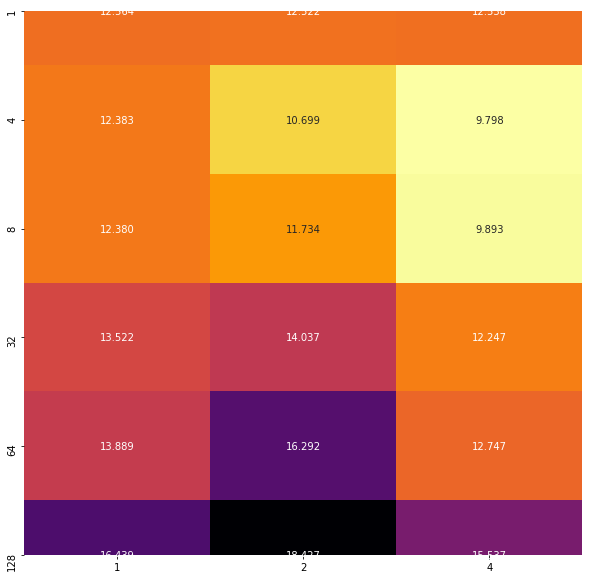

In [14]:
import seaborn as sns

df_times=pd.DataFrame(times_array.T,partitions,workers)


fig,ax=plt.subplots(figsize=[10,10])


sns.heatmap(df_times,cmap='inferno_r',square=False,annot=True,fmt='.3f',cbar=False,ax=ax)
#plt.ylabel('workers')
#plt.xlabel('partitions')
plt.show()

## Nations represented in research

We will now try to gather information on the research, from wich country it comes form

In [15]:
cluster = LocalCluster(n_workers=4,threads_per_worker=2) 
client  = Client(cluster)
#client = Client('localhost:8786')
client

Client Scheduler: tcp://127.0.0.1:60073 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 8.43 GB


In [6]:
#b.take(4)[3]['metadata']#['authors']#[0]['affiliation']['location']['country']

def country_getter(paper_dict):
    
    authors = paper_dict['metadata']['authors']
    countries = {}
    for author in authors:
        try:
            
            country = author['affiliation']['location']['country']

                
        except:
            country = 'Not Available'
            
        if country not in countries.keys():
            country = country.replace(' Correspondence', '').replace(' Correspondencia', '').replace(';','').replace(':','')
            country = country.replace('. •', '').replace('.','').replace(' ²Our Research','').replace(' A B S T R A C T', '')
            c_list = country.split(', ')
            for c in c_list:
                if c not in countries.keys():
                    countries[c] = 1
                else:
                    countries[c] +=1
        else:
            countries[country]+=1
    
    return countries
        


In [17]:
countries = b.map(country_getter).fold(reduce_counts).compute()

#countries = db.from_sequence(flist).repartition(len(flist)).map(open).map(json.load).map(country_getter).fold(reduce_counts).compute()

In [18]:
df     = pd.DataFrame(list(countries.items()),columns = ['Country','N_of_people'])
replacements     = {'PR China':'China',"People's Republic of China":'China','China (':'China','P R China':'China',
                    'ROC':'Taiwan',
                    'Mexico City':'Mexico',
                    'Japan (':'Japan',
                    'UK':'United Kingdom', 'UK)':'United Kingdom', 'Public Health England':'United Kingdom',
                    'UK A R':'United Kingdom','Scotland':'United Kingdom',
                    'Spain Address':'Spain', 'España':'Spain', 'Spain email':'Spain', 'Spain 11':'Spain',
                    '4 Switzerland':'Switzerland',
                    'U.S.A':'USA', 'United States of America':'USA', 'United States':'USA', 'The United States of America':'USA',
                    'UT':'USA', 'Ann Arbor':'USA', 'Unites States of America':'USA',
                    'Brasil':'Brazil', 'Brazil R':'Brazil', 'Brazil (':'Brazil',
                    'Österreich':'Austria', 'Austria *Correspondence':'Austria',
                    'Italien':'Italy', 'Italia':'Italy',
                    'Iran (the Islamic Republic of':'Iran',
                    'Osmaniye':'Turkey', 'Gokhan':'Turkey',
                    'the Netherlands':'The Netherlands', 'Netherlands':'The Netherlands',
                    'Korea':'South Korea', 'Republic of Korea':'South Korea',
                    'SA Avenida Italia':'Uruguay',
                    'Canada ²Our Research':'Canada',
                    'Valledupar Colombia':'Colombia',
                    'New Caledonia':'France',
                    'Schweden':'Sweden', 
                    'Norwegen':'Norway',
                    '7 Germany':'Germany', 'Deutschland':'Germany'
                    }

df     = df.replace(replacements)
df_new = df.groupby(by='Country',axis=0).sum()

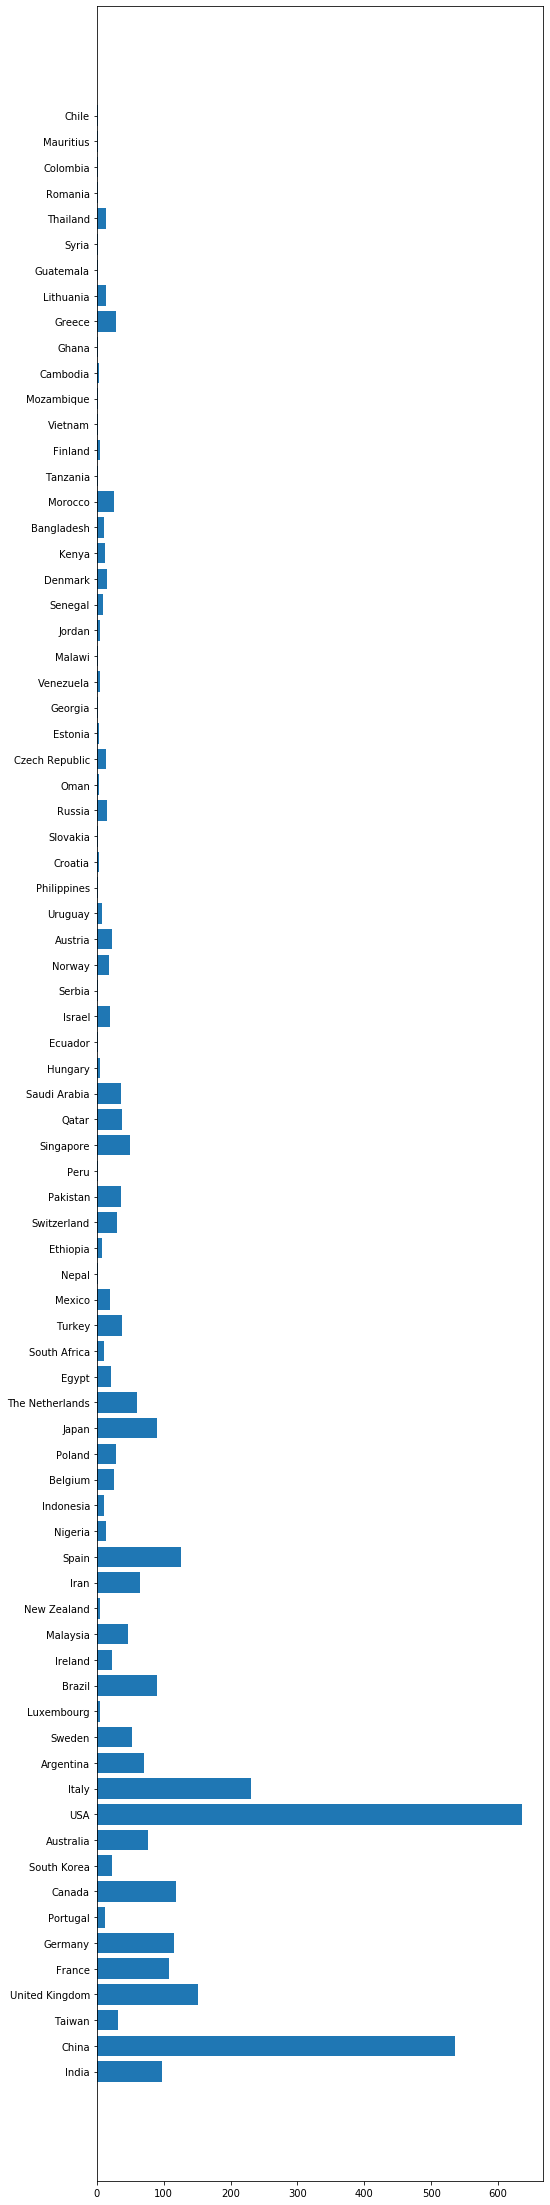

In [19]:
plt.figure(figsize=(8,40))
plt.barh(df[df['Country']!='Not Available']['Country'],df[df['Country']!='Not Available']['N_of_people'])
plt.show()

In [20]:
partitions = [1,4,8,32,64,128]
workers = [1,2,4]
times_array=np.zeros([len(workers),len(partitions)])

for i in range(len(workers)):
    for j in range(len(partitions)):
        
        cluster = LocalCluster(n_workers= workers[i],threads_per_worker=2)
        client = Client(cluster)
        
        b = db.read_text(flist).map(json.loads).repartition(partitions[j])
        time1 = time.time()
        
        country_count = b.map(country_getter).fold(reduce_counts).compute()
        
        times_array[i,j] = time.time() - time1
        
        client.close()
        cluster.close()
        

C:\Users\luca3\Anaconda3\lib\site-packages\distributed\dashboard\core.py:72: UserWarning: 
Failed to start diagnostics server on port 8787. [WinError 10048] Di norma è consentito un solo utilizzo di ogni indirizzo di socket (protocollo/indirizzo di rete/porta)
  warnings.warn("\n" + msg)


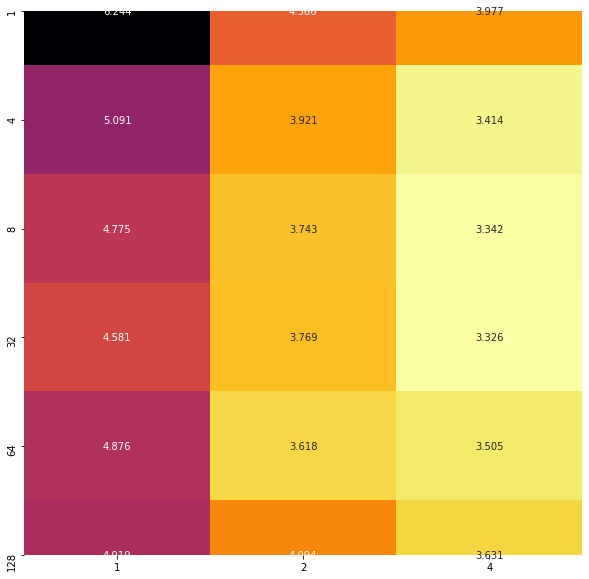

In [21]:
df_times=pd.DataFrame(times_array.T,partitions,workers)


fig,ax=plt.subplots(figsize=[10,10])


sns.heatmap(df_times,cmap='inferno_r',square=False,annot=True,fmt='.3f',cbar=False,ax=ax)
#plt.ylabel('workers')
#plt.xlabel('partitions')
plt.show()

## NPL

In [7]:
import io
def load_wordlist(fname):
    words = {}
    
    with io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore') as fin:
        n, d = map(int, fin.readline().split())
        # n = number of words
        # d = vector dimension
        
        
        embeddings = np.zeros((n, d), dtype=np.float32)
        
        for i, line in enumerate(fin):
            tokens = line.rstrip().split(' ')
            words[tokens[0]] = i
            embeddings[i, :] = np.array(tokens[1:], dtype=np.float32) 
                
        return words, embeddings

In [8]:
t1 = time.time()
words, embedding = load_wordlist('wiki.en.vec')
print('Time = ', np.round((time.time() - t1)/60), 'm')

Time =  7.0 m


In [14]:
def sanitize_text(text):
    forbidden_chars = ".,()[]:*><;°%/+"
    for forbidden_ch in forbidden_chars :
        text = text.replace(forbidden_ch,"")
    return(text.lower())

def extract_title(b):
    title = b['metadata']['title']
    title = sanitize_text(title)
    #print(title)
    title = title.split()
    return {'paper_id':b['paper_id'], 'title': title}

def get_ind_list(b):
    # words = parole con indicy
    title = b['title']
    ind = []
    for word in title:
        #if word != '' and word in pre_words:            
            #ind.append(words[word])
            #print(word)
        ind.append(words.get(word))
    return {'paper_id':b['paper_id'], 'title': ind}


def get_ind_list2(title):
    # words = parole con indicy
    words = json.load(open('words_finder.json'))
    ind = []
    for word in title:
        #if word != '' and word in pre_words:            
            #ind.append(words[word])
            #print(word)
        ind.append(words.get(word))
    return ind



def get_ind_list3(title):
    words = client.gather(w_future)
    ind = []
    for word in title:
        #if word != '' and word in pre_words:            
            #ind.append(words[word])
            #print(word)
        ind.append(words.get(word))
    return ind    
   
def get_embeddings_list(b):
    
    inds = b['title']
    
    fp = io.open('wiki.en.vec', 'r', encoding='utf-8', newline='\n', errors='ignore')
    
    emb = []
    
    inds = list(filter(None, inds))
    
    if len(inds)==0:
        return []
    m = max(inds)
    for i, line in enumerate(fp):
        if i in inds:
            tokens = line.rstrip().split(' ')
            emb.append(np.array(tokens[1:], dtype=np.float32))
        elif i > m:
            break
    fp.close()
    return {'paper_id':b['paper_id'], 'title_embedding': emb}

def get_embeddings_list2(b):
    
    inds = b['title']
    
    inds = list(filter(None, inds))
    
    if len(inds)==0:
        return {'paper_id':b['paper_id'], 'title_embedding': []}  
    
    emb = [embedding[index] for index in inds]
    

    

    return {'paper_id':b['paper_id'], 'title_embedding': emb}

In [27]:
cluster = LocalCluster(n_workers=4,threads_per_worker=2) 
client  = Client(cluster)
#client = Client('localhost:8786')
client

Client Scheduler: tcp://127.0.0.1:51076 Dashboard: http://127.0.0.1:51077/status,Cluster Workers: 4 Cores: 8 Memory: 8.43 GB


In [16]:
prova = b.map(extract_title).map(get_ind_list).map(get_embeddings_list).take(9)
prova[2]

{'paper_id': '000a0fc8bbef80410199e690191dc3076a290117',
 'title_embedding': [array([-0.12278  , -0.036748 ,  0.20728  , -0.018277 , -0.0016348,
          0.023735 , -0.03712  , -0.28608  , -0.19088  , -0.068688 ,
          0.061755 , -0.052416 ,  0.16867  , -0.1108   , -0.11308  ,
         -0.27392  , -0.30827  ,  0.18204  ,  0.096594 ,  0.29725  ,
         -0.050727 ,  0.023406 , -0.33813  , -0.10599  , -0.11249  ,
          0.066722 ,  0.14842  , -0.31099  , -0.09372  ,  0.0027705,
         -0.16806  ,  0.20955  , -0.23591  ,  0.070785 , -0.25399  ,
         -0.1121   , -0.12584  , -0.11348  , -0.13821  , -0.37261  ,
          0.1712   ,  0.091039 ,  0.12721  ,  0.033067 , -0.033074 ,
          0.03804  , -0.18015  ,  0.043457 ,  0.099211 ,  0.037043 ,
         -0.0035936, -0.35885  , -0.1046   , -0.24532  ,  0.12304  ,
          0.11229  ,  0.0019709,  0.16426  ,  0.051579 ,  0.081311 ,
         -0.0034787, -0.17466  ,  0.30059  , -0.23183  , -0.017487 ,
          0.28647  ,  0.399

In [17]:
title_embeddings = b.map(extract_title).map(get_ind_list).map(get_embeddings_list).compute()

In [18]:
title_embeddings[200]

{'paper_id': '00df6bbf768b081f1a472f3b121a9b48b04ac85f',
 'title_embedding': [array([-1.1112e-01, -1.3859e-03, -1.7780e-01,  6.4508e-02, -2.4037e-01,
          3.1087e-02, -3.0144e-02, -3.6883e-01, -4.3855e-02,  2.4831e-01,
          7.8633e-02, -1.6072e-01,  1.0528e-01, -9.6220e-02, -7.7742e-02,
         -2.8262e-01, -1.3013e-01,  5.6083e-03,  1.9406e-01,  1.9287e-01,
         -1.0955e-01,  2.3008e-01, -1.9911e-01,  1.8836e-01, -2.1861e-01,
          1.7505e-03, -9.3017e-02, -2.5064e-01,  3.4323e-02,  1.7047e-01,
         -9.4408e-02,  1.4420e-01, -1.8533e-01,  1.6850e-01, -1.6582e-01,
         -6.1712e-02, -1.0346e-02, -7.8817e-02,  2.0596e-01, -1.2286e-01,
         -6.4035e-02, -4.0983e-02, -2.1272e-01,  9.7636e-02, -5.8569e-02,
         -4.4869e-02,  2.8206e-02, -1.2619e-01,  1.2063e-02, -1.9177e-01,
         -4.4824e-02, -8.1765e-02, -7.3723e-02,  3.7251e-02, -7.5625e-02,
          8.5609e-03,  6.2612e-02,  2.2144e-01, -1.0765e-01,  1.6170e-01,
          6.5163e-02, -3.8164e-01,  

In [23]:
from scipy import spatial

def cosine_similarity(a, b):
    
    m1, m2 = set(range(len(a))), set(range(len(a)))
    l = min(len(a), len(b))
    cs = 0
    
    for i in np.arange(l):
        
        emb_t1 = np.copy(a)[[*m1]]
        emb_t2 = np.copy(b)[[*m2]]
        min_dist = 1
        
        for ix1, word1 in enumerate(emb_t1):
            for ix2, word2 in enumerate(emb_t2):
                new_dist = spatial.distance.cosine(word1, word2)
                if new_dist < min_dist:
                    min_dist = new_dist
                    rm = [ix1, ix2]
        
        m1 = m1 - set([rm[0]])
        m2 = m2 - set([rm[1]])
        cs = cs + min_dist
    
    return 1 - cs/l




In [26]:
similarities = np.zeros([10,10])
for i in range(10):
    for j in range(10):
        try:
            similarities[i,j] = cosine_similarity(title_embeddings[i]['title_embedding'],title_embeddings[j]['title_embedding'])
        except:
            pass

In [25]:
title_embeddings[:10]

[{'paper_id': '0000b93c66f991236db92dc16fa6db119b27ca12',
  'title_embedding': [array([-0.12278  , -0.036748 ,  0.20728  , -0.018277 , -0.0016348,
           0.023735 , -0.03712  , -0.28608  , -0.19088  , -0.068688 ,
           0.061755 , -0.052416 ,  0.16867  , -0.1108   , -0.11308  ,
          -0.27392  , -0.30827  ,  0.18204  ,  0.096594 ,  0.29725  ,
          -0.050727 ,  0.023406 , -0.33813  , -0.10599  , -0.11249  ,
           0.066722 ,  0.14842  , -0.31099  , -0.09372  ,  0.0027705,
          -0.16806  ,  0.20955  , -0.23591  ,  0.070785 , -0.25399  ,
          -0.1121   , -0.12584  , -0.11348  , -0.13821  , -0.37261  ,
           0.1712   ,  0.091039 ,  0.12721  ,  0.033067 , -0.033074 ,
           0.03804  , -0.18015  ,  0.043457 ,  0.099211 ,  0.037043 ,
          -0.0035936, -0.35885  , -0.1046   , -0.24532  ,  0.12304  ,
           0.11229  ,  0.0019709,  0.16426  ,  0.051579 ,  0.081311 ,
          -0.0034787, -0.17466  ,  0.30059  , -0.23183  , -0.017487 ,
           0.

In [34]:
title_embeddings_2 = []

for title in title_embeddings:
    
    try:
        title_embeddings_2.append({'paper_id':title['paper_id'],'title_embedding': [a.tolist() for a in title['title_embedding']]})
    except:
        pass

In [ ]:
for title in title_embeddings[:10]:
    print(title)

In [38]:
with open('title_embeddings.json','w') as f:

    json.dump(title_embeddings_2,f)

In [37]:
title_embeddings_2[1]

{'paper_id': '000a0fc8bbef80410199e690191dc3076a290117',
 'title_embedding': [[-0.12278000265359879,
   -0.036747999489307404,
   0.2072799950838089,
   -0.01827700063586235,
   -0.0016347999917343259,
   0.02373499982059002,
   -0.03711999952793121,
   -0.286080002784729,
   -0.19088000059127808,
   -0.06868799775838852,
   0.06175500154495239,
   -0.05241600051522255,
   0.16866999864578247,
   -0.11079999804496765,
   -0.11308000236749649,
   -0.2739199995994568,
   -0.30827000737190247,
   0.1820400059223175,
   0.09659399837255478,
   0.29725000262260437,
   -0.0507269985973835,
   0.023406000807881355,
   -0.33812999725341797,
   -0.10599000006914139,
   -0.11248999834060669,
   0.06672199815511703,
   0.14842000603675842,
   -0.31099000573158264,
   -0.09371999651193619,
   0.002770500024780631,
   -0.16806000471115112,
   0.20954999327659607,
   -0.23590999841690063,
   0.07078500092029572,
   -0.2539899945259094,
   -0.11209999769926071,
   -0.1258399933576584,
   -0.113480001

In [39]:
len(title_embeddings_2)

1058